In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
import os
import shutil
import sys

In [4]:
# Load dataset
dataset_dir = './data/train'
labels = pd.read_csv('./data/labels.csv')

In [5]:
# Number of classes
n_class = len(labels.breed.unique())
n_class

120

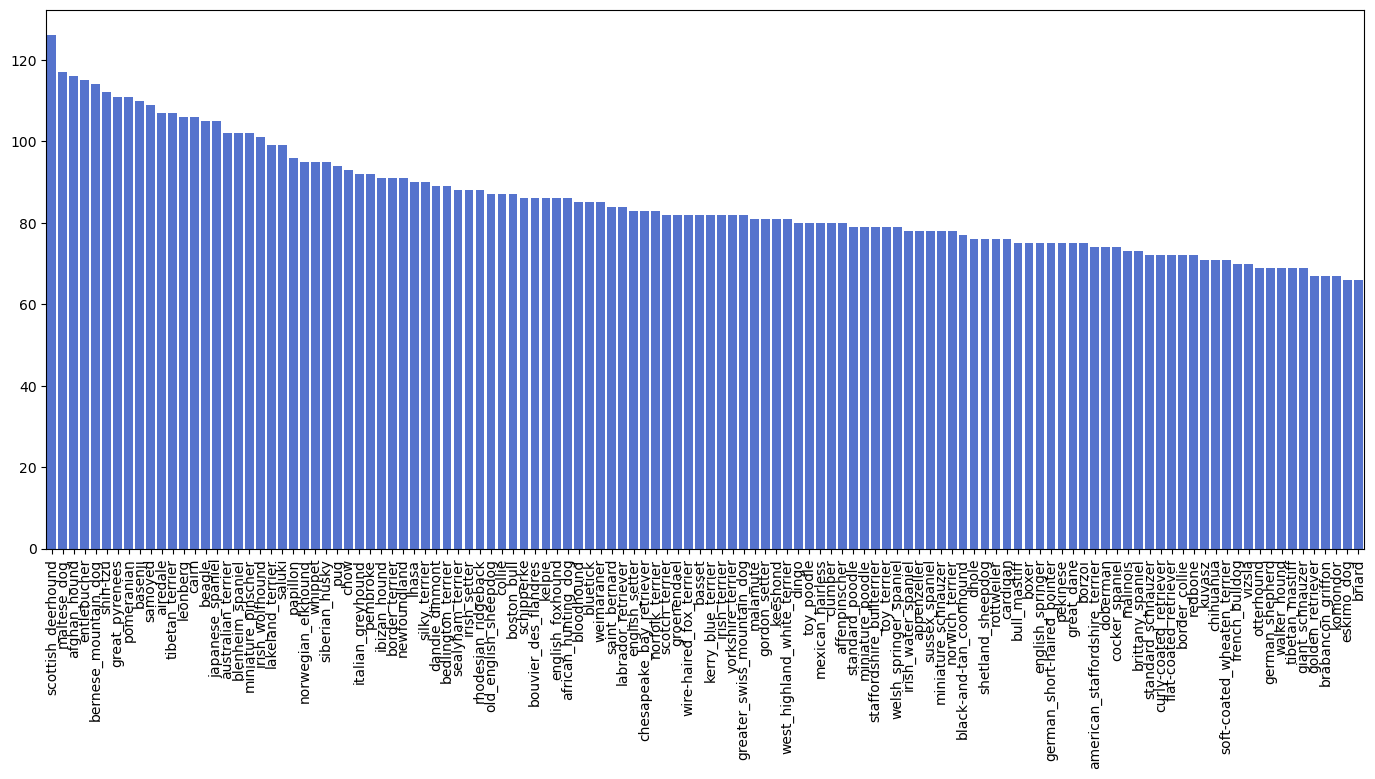

In [6]:
# Distribution of classes in the train dataset
import seaborn as sns
data = labels.breed.value_counts()

plt.figure(figsize=(17,7))
sns.barplot(x=data.index, y=data.values, color='royalblue')
plt.xticks(rotation=90)
plt.show()

In [7]:
import os

def make_dir(x):
    if os.path.exists(x)==False:
        os.makedirs(x)
        
base_dir = './subset'
make_dir(base_dir)

In [8]:
# Set up directories for the training data
train_dir = os.path.join(base_dir, 'train')
make_dir(train_dir)

In [9]:
# Loop through images
breeds = labels.breed.unique()
for breed in breeds:
    # Make folder for each breed
    _ = os.path.join(train_dir, breed)
    make_dir(_)
    
    # Copy images to the corresponding folders
    images = labels[labels.breed == breed]['id']
    for image in images:
        source = os.path.join(dataset_dir, f'{image}.jpg')
        destination = os.path.join(train_dir, breed,f'{image}.jpg')                             
        shutil.copyfile(source, destination)

In [10]:
# Set batch size 64 as global variable
batch_size = 64

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255) # rescale pixel values to [0,1] to reduce memory usage

train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='sparse',
    seed=123)

Found 10222 images belonging to 120 classes.


In [12]:
from tensorflow.keras.applications import InceptionResNetV2

inception_bottleneck = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

219070464/219055592 [==============================] - 46s 0us/step


In [14]:
# The shape of the features
feature_shape = inception_bottleneck.layers[-1].output_shape[1:]
print(f'The shape of each feature tensor is: {feature_shape}')

# Height, width and depth of the tensor
h = inception_bottleneck.layers[-1].output_shape[1]
w = inception_bottleneck.layers[-1].output_shape[2]
d = inception_bottleneck.layers[-1].output_shape[3]

The shape of each feature tensor is: (8, 8, 1536)


In [16]:
# Number of training samples
train_samples = len(labels)

# Initialize tensors with zeros
X_train = np.zeros(shape=(train_samples, h, w, d), dtype=np.float32) # specify dtype as float32
y_train = np.zeros(shape=(train_samples))

# Update the tensors with the features outputed by the bottleneck model
len_ = 0
for input_batch, label_batch in train_generator:
    features_batch = inception_bottleneck.predict(input_batch)
    X_train[len_:len_+len(features_batch)] = features_batch
    y_train[len_:len_+len(features_batch)] = label_batch
    len_+=len(features_batch)
    if len_ == train_samples:
        break

ResourceExhaustedError:  OOM when allocating tensor with shape[32,64,147,147] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node inception_resnet_v2/conv2d_2/Conv2D (defined at C:\Users\sanim\AppData\Local\Temp\ipykernel_23048\1430411321.py:11) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_16601]

Function call stack:
predict_function


In [17]:
# Shape of the feature tensors -- 10222 samples, each with shape (8,8,1536)
size = sys.getsizeof(X_train)/(1024*1024)
print(f'Shape: {X_train.shape}\nSize: {size:.3g}MB')

Shape: (10222, 8, 8, 1536)
Size: 3.83e+03MB


In [18]:
# Flatten the feature tensors to 1D vectors 
X_train = np.reshape(X_train, (train_samples, h*w*d)) 
shape = X_train.shape
print(f'Shape: {shape}')

Shape: (10222, 98304)


In [19]:
# Build the final fully connected dense layers for classification
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=h*w*d))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(n_class, activation='softmax')) # using softmax, the result could be interpreted in probability distribution

# Compile model using the popular'adam' optimizer
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

ResourceExhaustedError: failed to allocate memory [Op:Mul]

In [ ]:
# Train the model
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
epochs = 50

history = model.fit(X_train, y_train,
         epochs=epochs,
         batch_size=batch_size,
         validation_split=0.1,
         callbacks=[early_stop],
         verbose=1)

In [ ]:
# Plot result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy
plt.plot(epochs, acc, label='Train accuracy')
plt.plot(epochs, val_acc, label='Val accuracy')
plt.title('Training & validation accuracy')
plt.legend()

# Loss
plt.figure()
plt.plot(epochs, loss, label='Train loss')
plt.plot(epochs, val_loss, label='Val loss')
plt.title('Training & validation loss')
plt.legend()
plt.show()

In [ ]:
import cv2
from PIL import Image

In [ ]:
# Dictionary of breeds for decoding the one-hot-encoded prediction
breed_label = {j:i for i,j in train_generator.class_indices.items()}

# Crop the image to square
def crop_center(pil_img):
    img_w, img_h = pil_img.size
    hw = min(pil_img.size)
    return pil_img.crop(((img_w - hw) // 2,
                         (img_h - hw) // 2,
                         (img_w + hw) // 2,
                         (img_h + hw) // 2))

# Resize & reshape image array, extract features and return prediction
def predict(pil_img):
    img_array = np.array(crop_center(pil_img))
    image_array = cv2.resize(img_array, (299,299))/255
    image_array = np.reshape(image_array,(1,299,299,3))
    features = inception_bottleneck.predict(image_array)
    X = features.reshape((1,-1))
    prediction = model.predict(X)
    return breed_label[prediction.argmax()]